In [56]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [57]:
import decorator
print(decorator.__version__)

4.4.2


+ 可视化facebook数据集

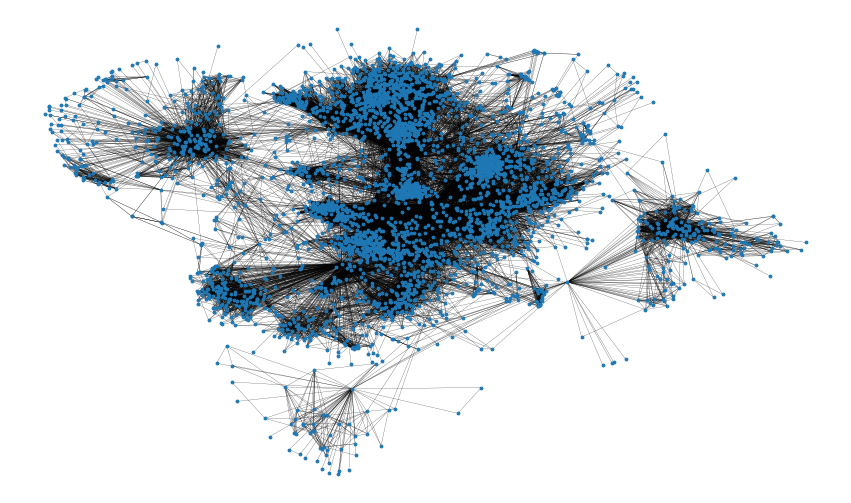

In [58]:
import pandas as pd
facebook = pd.read_csv(
    "facebook_combined.txt",
    sep=" ",
    names=["start_node", "end_node"],
)
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_settings = {"node_size": 8,  "width": 0.2, "with_labels": False}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_settings)

In [59]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes: %d" % n)
print("Number of edges: %d" % m)
print("Number of connected components: %d" % nx.number_connected_components(G))

Number of nodes: 4039
Number of edges: 88234
Number of connected components: 1


+ 数据集中的节点特征均为anonymized feature,统计特征个数

In [60]:
n_feat = 0
for num in [0,107,348,414,686,698,1684,1912,3437,3980]:
    with open('facebook/'+str(num)+'.featnames') as f:
        for line in f:
            n_feat = max(n_feat,int(line.split()[-1]))
n_feat += 1
print('特征个数: ',n_feat)

特征个数:  1283


In [68]:
features = np.zeros((n, n_feat))
for num in [0,107,348,414,686,698,1684,1912,3437,3980]:
    feature_index = []
    with open('facebook/'+str(num)+'.featnames') as f:
        for line in f:
            feature_index.append(int(line.split()[-1])) 
    with open('facebook/'+str(num)+'.feat') as f:
        for line in f:
            node_id  = int(line.split()[0])
            features[node_id,feature_index[:]] = list(map(int, line.split()[1:]))

+ 标签矩阵维数

In [69]:
features.shape

(4039, 1283)

+ 标签矩阵可视化

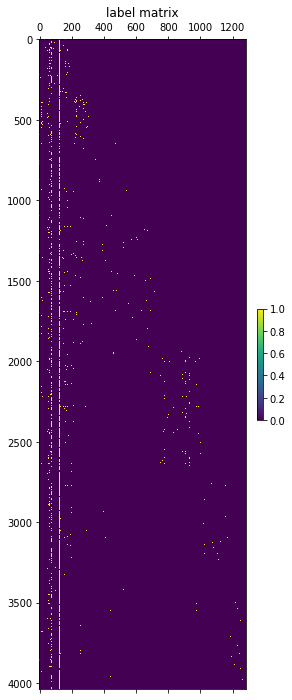

In [70]:
import matplotlib.pyplot as plt
ax = plt.matshow(features)
plt.colorbar(ax.colorbar, fraction=0.025)
plt.title("label matrix")
plt.show()

+ 选择anonymized feature 127： locale， 1表示是，0表示否；可视化如下

In [71]:
features = 2*features-1

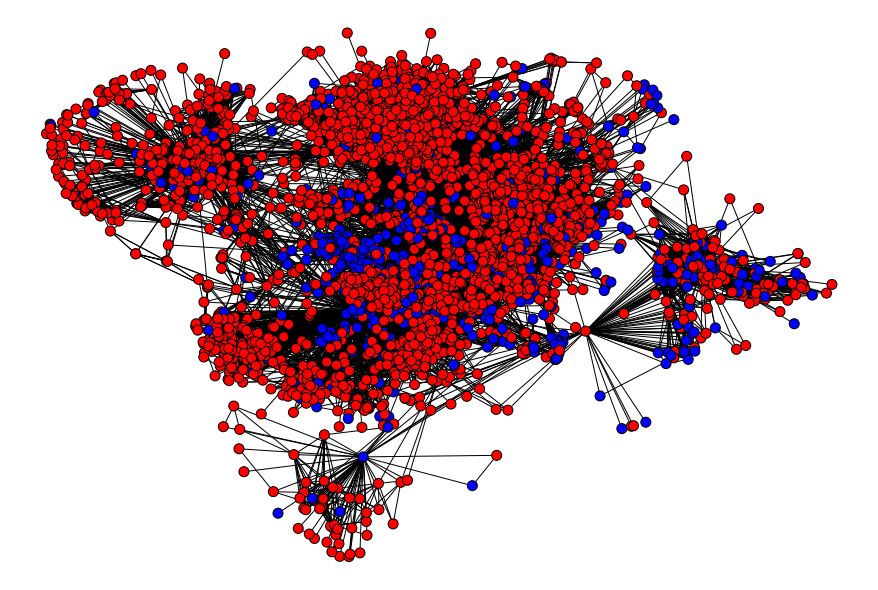

In [72]:
feat_id = 127
labels = features[:, feat_id]
plt.figure(figsize=(12,8))
nx.draw(G, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=100, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000")
plt.show()

+ 选择30%的节点标签用于预测

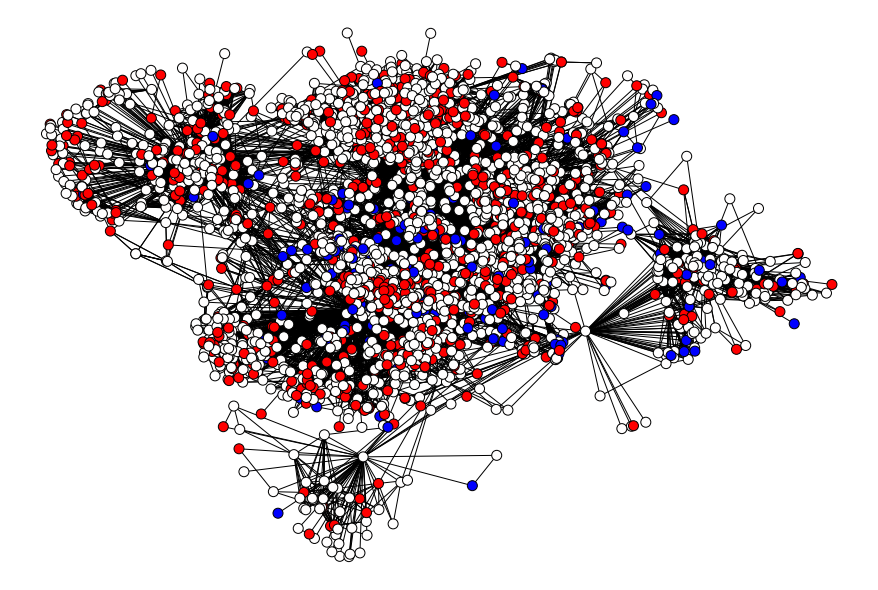

In [73]:
random.seed(123)
proportion_nodes = 0.3
labeled_nodes = random.sample(G.nodes(), int(proportion_nodes * n))

known_labels = np.zeros(n)
known_labels[labeled_nodes] = labels[labeled_nodes]

plt.figure(figsize=(12,8))
nx.draw(G, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = known_labels, node_size=100, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.show()

In [74]:
alpha = 0.7
L_sym = nx.normalized_laplacian_matrix(G)

Y = np.zeros((n,2))
Y[known_labels==-1, 0] = 1
Y[known_labels==1, 1] = 1
I = np.identity(n)

# Create the F-pred matrix
F_pred = np.linalg.inv(I*(1-alpha) + L_sym) * Y
# Identify the prediction as the argmax
pred = np.array(np.argmax(F_pred, axis=1)*2-1).flatten()
# Compute the accuracy score
succ_rate = accuracy_score(labels, pred)

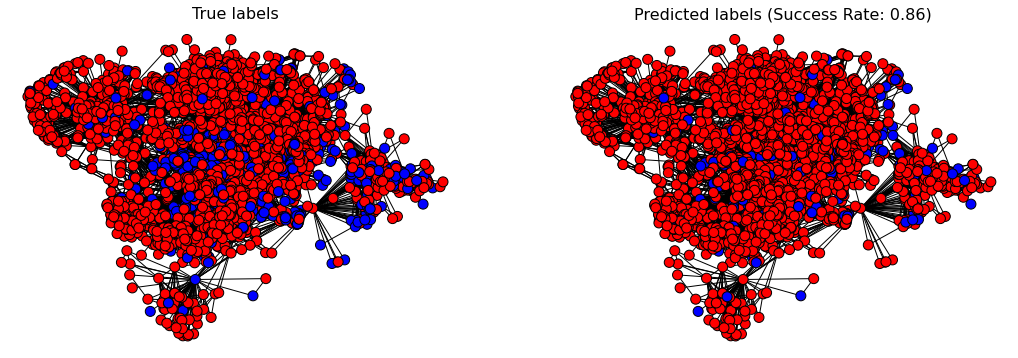

In [75]:
plt.figure(figsize=(18, 6))
f, axarr = plt.subplots(1, 2, num=1)

# Plot true values
plt.sca(axarr[0])
nx.draw(G, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=100, pos=pos)
axarr[0].set_title('True labels', size=16)
plt.gca().collections[0].set_edgecolor("#000000")

# Plot predicted values
plt.sca(axarr[1])
nx.draw(G, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = pred, node_size=100, pos=pos)
axarr[1].set_title('Predicted labels (Success Rate: %.2f)' % succ_rate, size=16)
plt.gca().collections[0].set_edgecolor("#000000")